In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [51]:
df =pd.read_csv(r"C:\Users\Jarvis\OneDrive\Documents\Downloads\AIML Dataset.csv")
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


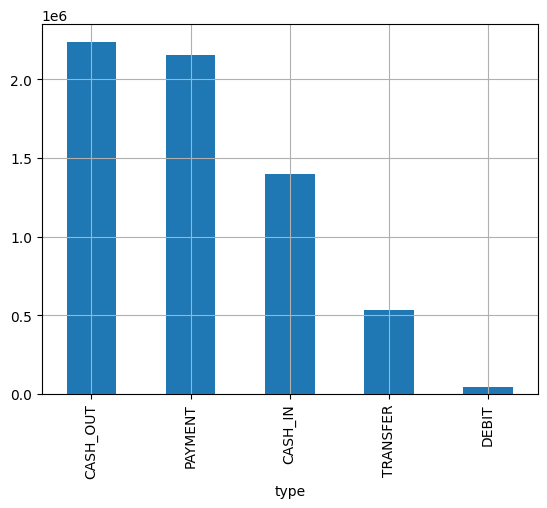

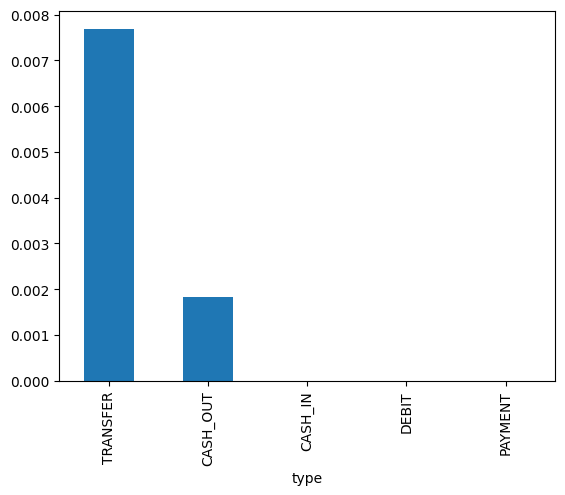

scale_pos_weight = 773.75
best thres 0.99774456
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.97      0.73      0.83      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.86      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524

AUC Score: 0.9986373258288311
Model saved successfully!


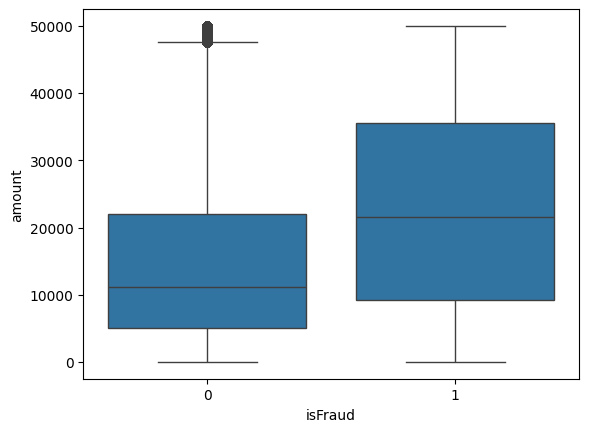

In [52]:
df['type'].value_counts().plot(kind='bar',grid=True)
plt.show()

avg_fraud_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
avg_fraud_type.plot(kind='bar')
plt.show()

sns.boxplot(data=df[df['amount']<50000],x='isFraud',y='amount')

df['difforig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['diffdest'] = df['newbalanceDest'] -  df['oldbalanceDest']
df['errorbal'] = (df['newbalanceOrig'] + df['newbalanceDest'])  - (df['oldbalanceDest'] - df['oldbalanceOrg'])

df_model = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
x = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

numeric = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
           'difforig', 'diffdest', 'errorbal']
categorical = ['type']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

scale_pos = (len(y_train) - sum(y_train)) / sum(y_train)
print(f"scale_pos_weight = {scale_pos:.2f}")

processer = ColumnTransformer(transformers=[
    ('num',StandardScaler(),numeric),
    ('cat',OneHotEncoder(drop='first'),categorical)
])

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos, 
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

model =Pipeline([
    ('prep',processer),
    ('clf',xgb)
])

model.fit(x_train,y_train)
y_prob = model.predict_proba(x_test)[:,-1]

precision,recall,thresholds = precision_recall_curve(y_test,y_prob)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
best_thresh =  thresholds[np.argmax(f1_score)]
print('best thres',best_thresh)

y_pred = (y_prob >= best_thresh).astype(int)
print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))

joblib.dump(model, "fraud_detection_model.pkl")
print("Model saved successfully!")

In [3]:
print('hello')


hello
